In [1]:
# 패키지 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

sns.set()

### 데이터셋 준비

In [3]:
# ETF 데이터 다운로드
tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
etf = yf.Tickers(tickers)
data = etf.history(start='2010-01-01', actions=False)
data.drop(['Open', 'Low', 'High', 'Volume'], axis=1, inplace=True)
data = data.droplevel(0, axis=1).resample('W').last()

[*********************100%***********************]  9 of 9 completed


In [4]:
# 수익률
rets = data.pct_change().fillna(0)

### 수정 켈리 베팅 전략 구현

In [5]:
# scipy.stats.norm 임포트
## N()을 구하기 위해 norm 함수 임포트
from scipy.stats import norm

<Axes: xlabel='Date'>

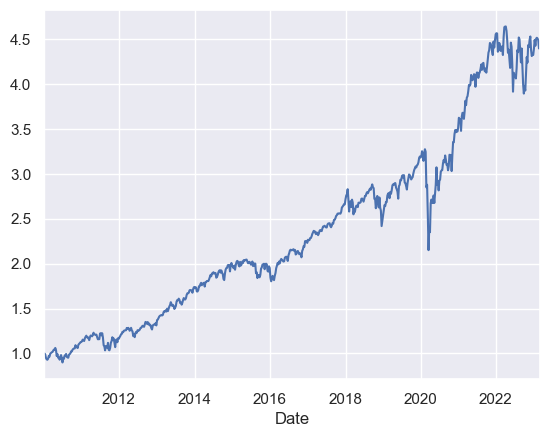

In [6]:
# EW 포트폴리오 수익률
port_rets = rets.mean(axis=1)
(1 + port_rets).cumprod().plot()

In [7]:
# 룩백 윈도우
lookback = 52

# 1년 롤링 샤프비율 계산
sharpe_ratio = (port_rets.rolling(lookback).mean() * np.sqrt(52) / port_rets.rolling(lookback).std())

# 켈리 베팅 비율 계산
kl_weights = pd.Series(2 * norm.cdf(sharpe_ratio) - 1, index=port_rets.index).fillna(0)

# 롱온리 가정 설정
kl_weights[kl_weights < 0] = 0

In [8]:
# 켈리 베팅 포트폴리오 수익률
kl_rets = (port_rets * kl_weights.shift()).fillna(0)
kl_cum_rets = (1 + kl_rets).cumprod() - 1

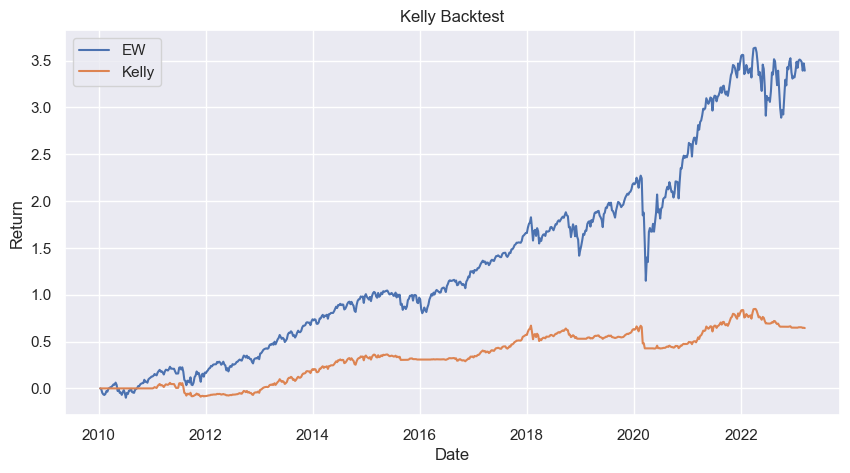

In [9]:
# 백테스팅 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot((1 + port_rets).cumprod() - 1, label='EW')
plt.plot(kl_cum_rets, label='Kelly')
plt.title('Kelly Backtest')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.show()

In [10]:
# 투가 비중 데이터프레임 생성 
kl_weights_df = pd.concat([kl_weights, 1 - kl_weights], axis=1, join='inner')
kl_weights_df.columns = ['portfolio', 'cash']

Text(0, 0.5, 'Weights')

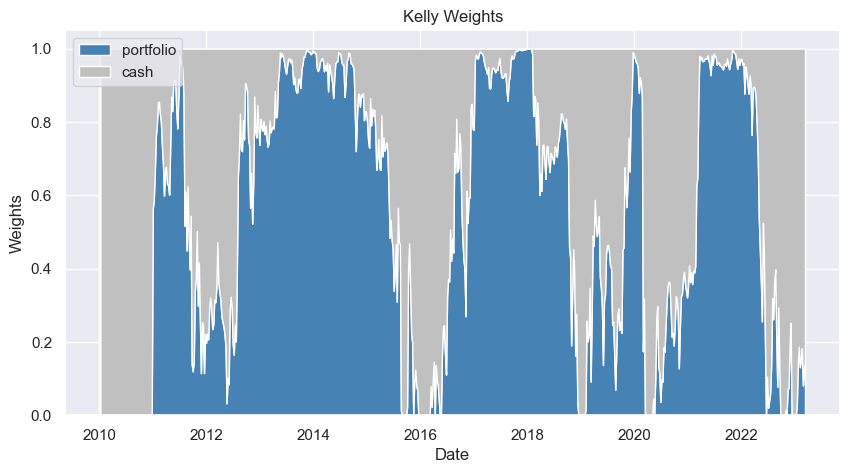

In [13]:
# 시계열 플랏 시각화
plt.figure(figsize=(10, 5))
plt.stackplot(kl_weights_df.index, kl_weights_df.T, labels=kl_weights_df.columns, colors=['steelblue', 'silver'])
plt.legend(loc='upper left')
plt.title('Kelly Weights')
plt.xlabel('Date')
plt.ylabel('Weights')